In this notebok I will process the audio files in the genres_original folder and save the mel spectrograms in the mel_spectrograms folder. I will also create a function to visualize the spectrograms.

First, we need to import the necessary libraries:

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
from pathlib import Path
from tqdm.notebook import tqdm  # For Jupyter notebook progress bars


In [17]:
data_dir_path = "/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data"

These are the parameters for the mel spectrogram:



In [18]:

# Parameters for mel spectrogram
SR = 22050  # Sample rate
N_MELS = 128  # Number of mel bands
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Number of samples between successive frames
DURATION = 30  # Duration of audio to process (in seconds)


In [19]:
def extract_features(audio_path):
    """
    Extract various audio features from an audio file
    """
    y, sr = librosa.load(audio_path, duration=DURATION, sr=SR)

    # Mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    # MFCCs
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # Zero crossing rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))

    # Tempo and beat
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sr)[0]

    # Chroma features
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    return {
        'mel_spectrogram': mel_spect_db,
        'mfccs': mfccs,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_contrast': spectral_contrast,
        'spectral_rolloff': spectral_rolloff,
        'zero_crossing_rate': zero_crossing_rate,
        'tempo': tempo,
        'chroma_stft': chroma_stft
    }

def create_melspectrogram_and_features(audio_path, output_dir, genre_name, audio_file_name):
    """
    Convert audio file to mel spectrogram, extract features, and save them
    """
    try:
        features = extract_features(audio_path)

        # Save mel spectrogram as numpy array
        mel_spectrogram_path = Path(output_dir) / genre_name / f"{audio_file_name.stem}.npy"
        np.save(str(mel_spectrogram_path), features['mel_spectrogram'])

        # Save other features in a separate dictionary or DataFrame
        features_dict = {k: v for k, v in features.items() if k != 'mel_spectrogram'}
        features_df = pd.DataFrame([features_dict])  # Convert to DataFrame
        features_df['genre'] = genre_name
        features_df['audio_file_name'] = audio_file_name.stem

        # Save features as CSV
        # features_csv_path = Path(output_dir) / genre_name / f"{audio_file_name.stem}_features.csv"
        # features_df.to_csv(str(features_csv_path), index=False)

        return True, features_df
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return False, None

def process_all_genres(input_dir, output_dir):
    """
    Process all audio files in genre subdirectories, extract features, and save them
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    genre_folders = [f for f in input_path.iterdir() if f.is_dir()]
    all_features_df = pd.DataFrame()

    for genre_folder in tqdm(genre_folders, desc="Processing genres", unit="genre"):
        genre_name = genre_folder.name
        genre_output = output_path / genre_name
        genre_output.mkdir(exist_ok=True)

        audio_files = list(genre_folder.glob('*.wav'))

        for audio_file in tqdm(audio_files, desc=f"Processing {genre_name}", unit="file", leave=False):
            success, features_df = create_melspectrogram_and_features(str(audio_file), str(output_path), genre_name, audio_file)
            if success:
                all_features_df = pd.concat([all_features_df, features_df], ignore_index=True)
            else:
                print(f"Failed to process: {audio_file.name}")
    
    # Save all features to a single CSV file
    all_features_csv_path = output_path / "all_features.csv"
    all_features_df.to_csv(str(all_features_csv_path), index=False)


In [20]:
# running the process
input_directory = data_dir_path + "/genres_original"
output_directory = data_dir_path + "/mel_spectrograms"
process_all_genres(input_directory, output_directory)

Processing genres:   0%|          | 0/10 [00:00<?, ?genre/s]

Processing pop:   0%|          | 0/100 [00:00<?, ?file/s]

Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.00027.wav: No librosa.feature attribute rhythm
Failed to process: pop.00027.wav
Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.00033.wav: No librosa.feature attribute rhythm
Failed to process: pop.00033.wav
Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.00032.wav: No librosa.feature attribute rhythm
Failed to process: pop.00032.wav
Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.00026.wav: No librosa.feature attribute rhythm
Failed to process: pop.00026.wav
Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.00030.wav: No librosa.feature attribute rhythm
Failed to process: pop.00030.wav
Error processing /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/pop/pop.

KeyboardInterrupt: 

In [6]:
# trying to deal with the single file that is not working
import soundfile as sf

y, sr = sf.read(data_dir_path + "/genres_original/jazz/jazz.00054.wav")


LibsndfileError: Error opening '/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/jazz/jazz.00054.wav': Format not recognised.

In [7]:
!ffmpeg -i "/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/jazz/jazz.00054.wav"

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [8]:
!ffmpeg -i /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/genres_original/jazz/jazz.00054.wav -ar 44100 -ac 2 /Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/jazz_converted.wav

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

## Visualizing the Mel Spectrograms

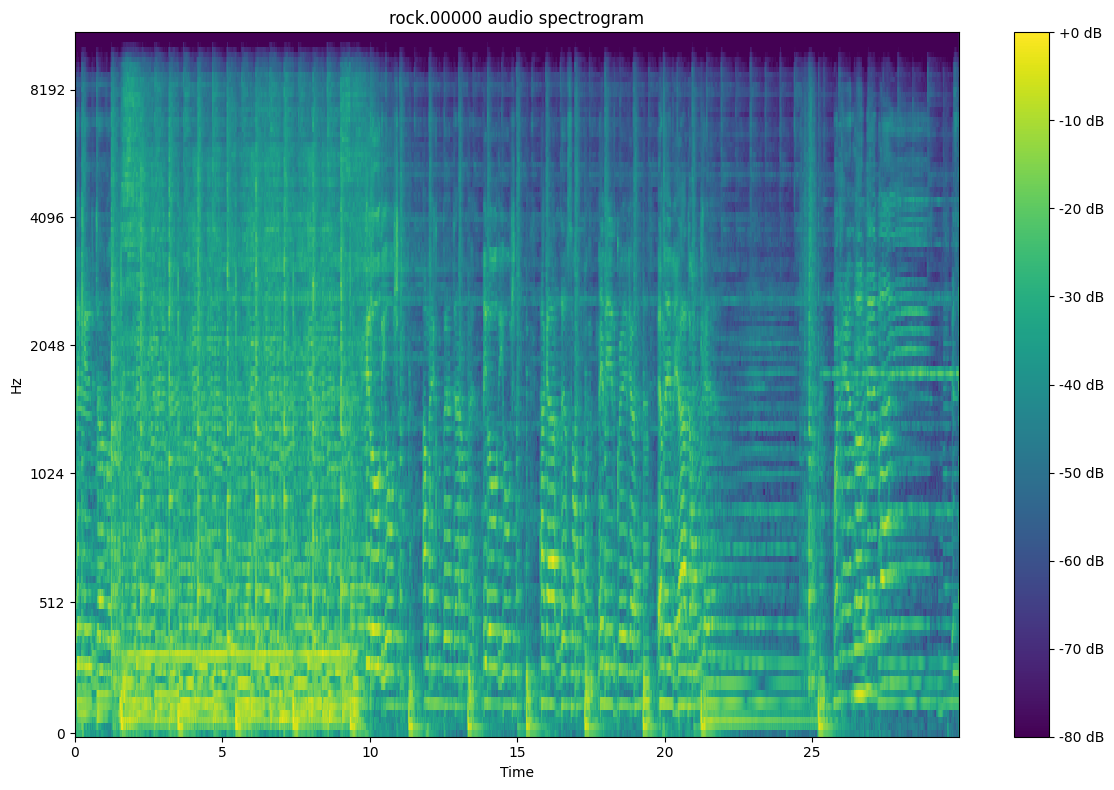

In [9]:
def plot_melspectrogram(npy_path, title=None):
    """
    Load and display a mel spectrogram from a .npy file

    Args:
        npy_path: Path to the .npy file
        title: Optional title for the plot
    """
    # Load the mel spectrogram
    mel_spect_db = np.load(npy_path)

    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(12, 8))

    # Display mel spectrogram
    img = librosa.display.specshow(
        mel_spect_db,
        sr=SR,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        ax=ax,  # Pass the axes object to specshow
        cmap='viridis'
    )

    # Add colorbar and labels using the img object and the explicit axes
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_title(title or 'Mel Spectrogram')
    plt.tight_layout()
    plt.show()

# Lets visualize a single file
npy_path = data_dir_path + "/mel_spectrograms/rock/rock.00000.npy"  # Replace with your path
plot_melspectrogram(npy_path, title="rock.00000 audio spectrogram")


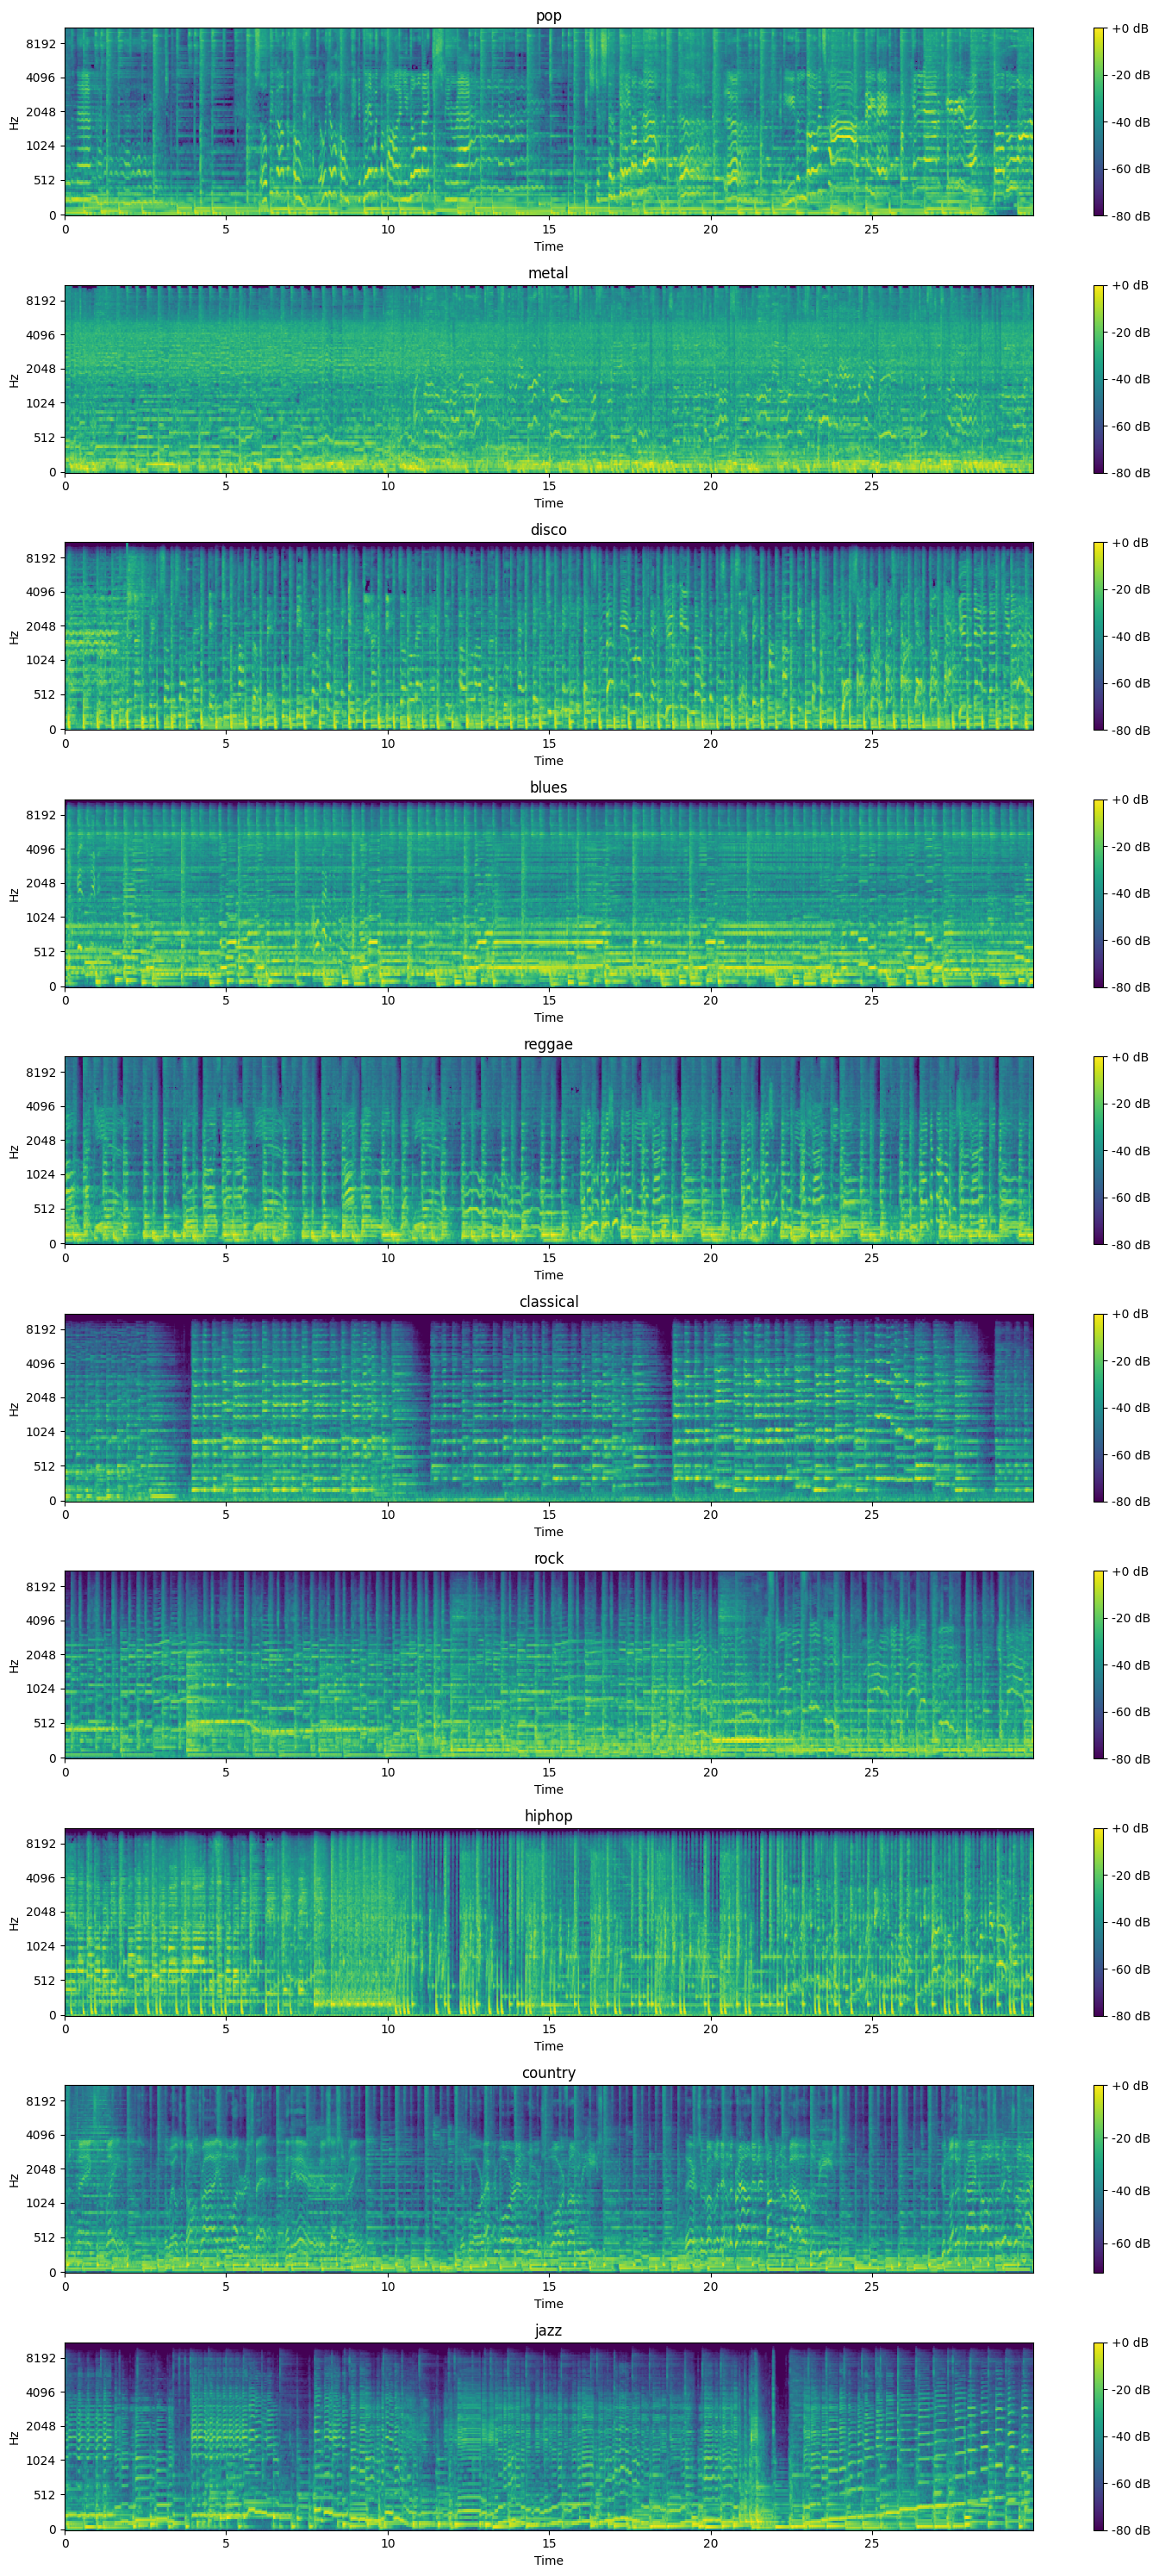

In [10]:

# To visualize multiple spectrograms from different genres:
def plot_multiple_spectrograms(base_path, num_per_genre=1):
    """
    Plot spectrograms from different genres
    
    Args:
        base_path: Path to mel_spectrograms directory
        num_per_genre: Number of examples to show per genre
    """
    base_path = Path(base_path)
    
    # Get list of genres
    genres = [d for d in base_path.iterdir() if d.is_dir()]
    
    # Create subplot grid
    fig = plt.figure(figsize=(15, 3*len(genres)))
    
    for i, genre_path in enumerate(genres):
        # Get first file in genre directory
        files = list(genre_path.glob('*.npy'))[:num_per_genre]
        
        for j, file in enumerate(files):
            plt.subplot(len(genres), num_per_genre, i*num_per_genre + j + 1)
            mel_spect_db = np.load(file)
            
            librosa.display.specshow(
                mel_spect_db,
                sr=SR,
                hop_length=HOP_LENGTH,
                x_axis='time',
                y_axis='mel',
                cmap='viridis'
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'{genre_path.name}')
    
    plt.tight_layout()
    plt.show()

# Example usage - show one spectrogram from each genre
plot_multiple_spectrograms(data_dir_path + "/mel_spectrograms", num_per_genre=1)

Qualitative Analysis: 

* **Pop**: The pop spectrogram shows a dynamic range of frequencies with noticeable energy throughout the spectrum. There are clear vertical lines indicating percussive elements and more sustained energy in the mid-frequencies, likely representing vocals and melodic instruments. The energy distribution appears relatively consistent across the time axis, with some variations indicating different musical sections.

* **Metal**: The metal spectrogram is characterized by very dense energy across a wide frequency range, especially in the lower and mid-frequencies. This suggests the presence of powerful, sustained instruments like electric guitars and bass. The spectrogram appears more uniform and dense compared to pop, indicating a generally high level of intensity throughout. There are also some prominent higher-frequency components, potentially from cymbals or lead guitar work.

* **Disco**: The disco spectrogram exhibits a strong presence in the lower and mid-frequencies, which is characteristic of the bass-heavy nature of disco music. There are rhythmic vertical patterns indicating strong beats and less dense energy in the higher frequencies compared to metal. The energy distribution looks relatively even across the time axis, reflecting the consistent dance rhythm.

* **Blues**: The blues spectrogram shows a significant amount of energy concentrated in the lower and mid-frequencies, representing instruments like guitars, bass, and vocals. The patterns appear somewhat less uniform than in genres like metal or disco, with variations in energy density and frequency distribution over time. There are some clear horizontal bands, which might correspond to sustained notes or vocal phrases.

* **Reggae**: The reggae spectrogram reveals a strong emphasis on the low frequencies, which is typical of the prominent bass lines in reggae music. There are rhythmic vertical patterns, but they might be less sharp and more spread out compared to disco. The energy distribution seems moderately consistent over time, with some variations likely corresponding to changes in the musical arrangement.

* **Classical**: The classical spectrogram displays a wide range of frequency activity, but often with more distinct separation between frequency bands. There are sections with less dense energy and sections with richer harmonic content, shown by horizontal lines. The patterns are less consistently rhythmic and more varied, reflecting the dynamic and often non-repeating structure of classical music. You can observe periods of higher frequency activity from instruments like violins and flutes, as well as lower frequency activity from cellos and basses.

* **Rock**: The rock spectrogram shares similarities with metal, showing substantial energy in the lower and mid-frequencies, indicative of electric guitars and bass. However, it may exhibit a slightly less dense and more varied pattern than metal. There are clear vertical lines representing drum hits and more sustained energy in the mid-frequencies. The intensity can fluctuate across the time axis, reflecting the dynamic nature of rock music.

* **Hiphop**: The hiphop spectrogram is characterized by strong, rhythmic energy in the lower frequencies, corresponding to the bass and kick drum. There can be significant activity in the mid-frequencies as well, likely from vocals and samples. The visual patterns often show distinct rhythmic blocks or segments, reflecting the beat-driven structure of hiphop.

* **Country**: The country spectrogram typically shows prominent energy in the mid-frequencies, which is characteristic of vocals and instruments like acoustic guitars and banjos. There might be less intense energy in the very low frequencies compared to genres like hiphop or reggae. The patterns appear relatively consistent with variations depending on instrumentation, with clear evidence of melodic lines and harmonic content.

* **Jazz**: The jazz spectrogram is characterized by a wide range of frequency activity and a somewhat less uniform energy distribution compared to more rhythmically driven genres. You can observe complex patterns with varying densities across the frequency spectrum, reflecting improvisation and diverse instrumentation. There can be strong activity in both the mid and higher frequencies, showcasing the interplay of various instruments like saxophones, trumpets, and pianos.

In [11]:
# load in the all_features
audio_df = pd.read_csv(data_dir_path + "/mel_spectrograms/all_features.csv")

# lets see the first 5 rows
audio_df.head()

mfccs  spectral_centroid  \
0  [-75.36613    83.33488    10.703896   14.45510...        2682.713195   
1  [-6.9001930e+01  7.3769997e+01 -1.2468982e+01 ...        2835.059302   
2  [-1.1316950e+02  4.1588139e+01  2.1516308e+01 ...        4225.564575   
3  [-7.3367416e+01  9.7464279e+01  1.6870550e+01 ...        2526.130443   
4  [-18.171194    72.29644     -4.867231    -0.35...        3070.645171   

   spectral_bandwidth  spectral_contrast  spectral_rolloff  \
0         2924.230380          17.915027       5957.288977   
1         2731.753172          16.844644       5945.014051   
2         3404.219303          17.243161       8483.032038   
3         2848.670626          19.143795       5554.674745   
4         2975.859194          17.167642       6652.968104   

   zero_crossing_rate       tempo  \
0            0.101915   83.354335   
1            0.137063   99.384014   
2            0.228737   95.703125   
3            0.103542  151.999081   
4            0.148740   95.703125   

                                         chroma_stft genre audio_file_name  
0  [0.30009085 0.37918484 0.47011843 0.32529423 0...   pop       pop.00027  
1  [0.54463905 0.35073337 0.38803208 0.33771315 0...   pop       pop.00033  
2  [0.44348058 0.4932909  0.37376222 0.47801247 0...   pop       pop.00032  
3  [0.46378902 0.28745398 0.31659603 0.24600798 0...   pop       pop.00026  
4  [0.40088522 0.5333807  0.29077682 0.3726285  0...   pop       pop.00030

In [13]:
# analysis on the features
from utils import plot_feature_interactive

plot_feature_interactive(audio_df, excluded_features=['genre', 'audio_file_name'])

SelectMultiple(description='Features:', options=('mfccs', 'spectral_centroid', 'spectral_bandwidth', 'spectral…

Dropdown(description='Plot Type:', options=('histogram', 'violinplot', 'boxplot'), value='histogram')

Output()

In [15]:
from utils import plot_feature_by_label_interactive

plot_feature_by_label_interactive(audio_df, label_name='genre', excluded_features=['genre', 'audio_file_name'])

SelectMultiple(description='Features:', options=('mfccs', 'spectral_centroid', 'spectral_bandwidth', 'spectral…

Output()